# Exercise 6

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Ex 6.1
# Create a 1D Gaussian kernel
def gaussian_1D_kernel(sigma):
    """
    Returns the 1D Gaussian kernel.

    Args:
        sigma : width of Gaussian kernel

    Returns:
        g : 1D Gaussian kernel
        gd : 1D Gaussian kernel derivative
    """
    if sigma == 0:
        return [1], [0]
    rule = 5
    x = np.arange(-rule * sigma, rule * sigma + 1)
    g = np.exp(-(x**2) / (2 * sigma**2))
    g = g / np.sum(g)  # normalize
    gd = -x / (sigma**2) * g
    return g, gd


sigma = 5
g, gd = gaussian_1D_kernel(sigma)
print(f"Gaussian kernel: {g.shape}\n{g}")
print(f"Gaussian kernel derivative: {gd.shape}\n{gd}")

Gaussian kernel: (51,)
[2.97344000e-07 7.92260076e-07 2.02817107e-06 4.98849588e-06
 1.17886174e-05 2.67660538e-05 5.83894041e-05 1.22380426e-04
 2.46443914e-04 4.76817795e-04 8.86369970e-04 1.58309083e-03
 2.71659473e-03 4.47890751e-03 7.09492087e-03 1.07981968e-02
 1.57900368e-02 2.21841741e-02 2.99455029e-02 3.88372236e-02
 4.83941606e-02 5.79383294e-02 6.66449422e-02 7.36540520e-02
 7.82085642e-02 7.97884820e-02 7.82085642e-02 7.36540520e-02
 6.66449422e-02 5.79383294e-02 4.83941606e-02 3.88372236e-02
 2.99455029e-02 2.21841741e-02 1.57900368e-02 1.07981968e-02
 7.09492087e-03 4.47890751e-03 2.71659473e-03 1.58309083e-03
 8.86369970e-04 4.76817795e-04 2.46443914e-04 1.22380426e-04
 5.83894041e-05 2.67660538e-05 1.17886174e-05 4.98849588e-06
 2.02817107e-06 7.92260076e-07 2.97344000e-07]
Gaussian kernel derivative: (51,)
[ 2.97344000e-07  7.60569673e-07  1.86591739e-06  4.38987637e-06
  9.90243860e-06  2.14128431e-05  4.43759471e-05  8.81139066e-05
  1.67581861e-04  3.05163389e-04  

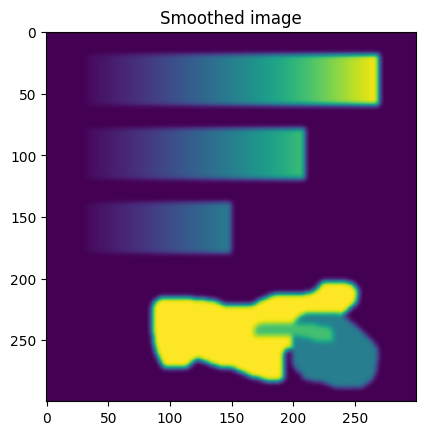

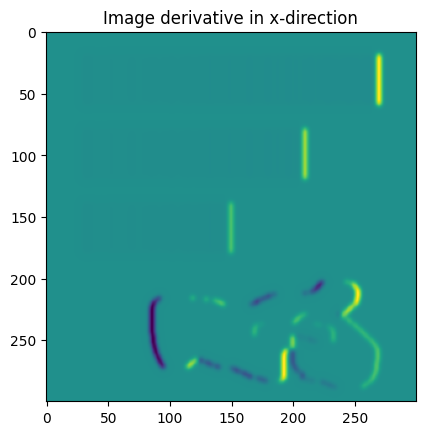

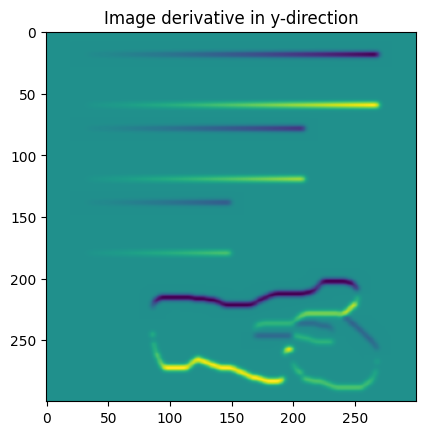

In [3]:
# Ex 6.2
# Apply the Gaussian kernel to the input image
def gaussian_smoothing(im, sigma):
    """
    Smooths the input image with a 1D Gaussian kernel.

    Args:
        im : input image
        sigma : width of Gaussian kernel

    Returns:
        I : smoothed image
        Ix : image derivative in x-direction
        Iy : image derivative in y-direction
    """
    g, gd = gaussian_1D_kernel(sigma)
    I = cv2.sepFilter2D(im, -1, g, g)
    Ix = cv2.sepFilter2D(im, -1, gd, g)
    Iy = cv2.sepFilter2D(im, -1, g, gd)
    return I, Ix, Iy


im = "media/week06_data/TestIm2.png"
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)
sigma = 2
I, Ix, Iy = gaussian_smoothing(im, sigma)

%matplotlib inline
# Display images
plt.imshow(I)
plt.title("Smoothed image")
plt.show()

plt.imshow(Ix)
plt.title("Image derivative in x-direction")
plt.show()

plt.imshow(Iy)
plt.title("Image derivative in y-direction")
plt.show()

Structure tensor: (2, 2, 300, 300)


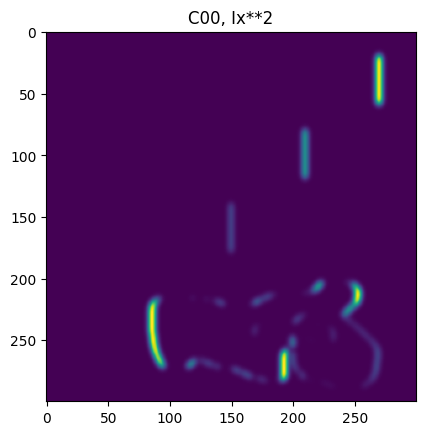

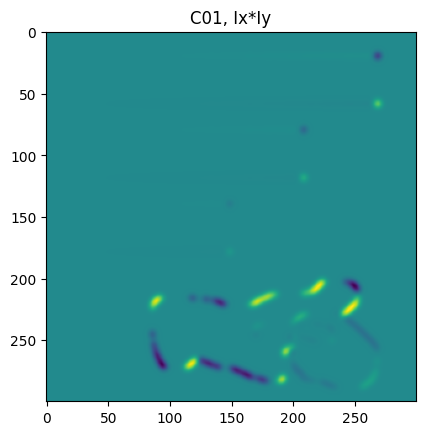

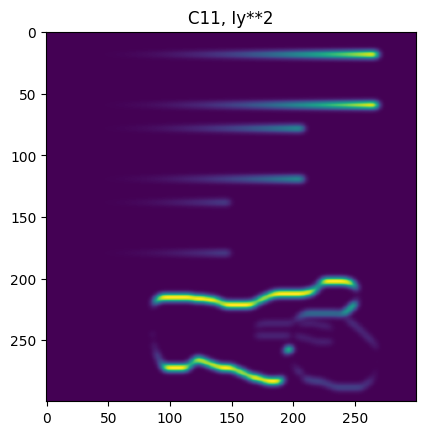

In [4]:
# Ex 6.3
# Create structure tensor using gaussian kernels
def structure_tensor(im, sigma, epsilon):
    """
    Computes the structure tensor C(x,y) of the input image.

    Args:
        im : input image
        sigma : Gaussian width to compute derivatives
        epsilon : Gaussian width to compute the structure tensor

    Returns:
        J : structure tensor
    """
    I, Ix, Iy = gaussian_smoothing(im, sigma)

    g_eps, g_eps_d = gaussian_1D_kernel(epsilon)
    C = np.zeros((2, 2))
    C00 = cv2.sepFilter2D(Ix**2, -1, g_eps, g_eps)
    C01 = cv2.sepFilter2D(Ix * Iy, -1, g_eps, g_eps)
    C10 = C01
    C11 = cv2.sepFilter2D(Iy**2, -1, g_eps, g_eps)
    # C00 = cv2.filter2D(Ix**2, -1, g_eps)
    # C01 = cv2.filter2D(Ix*Iy, -1, g_eps)
    # C10 = C01
    # C11 = cv2.filter2D(Iy**2, -1, g_eps)
    C = np.array([[C00, C01], [C10, C11]])

    return C


sigma = 2
epsilon = 2
C = structure_tensor(im, sigma, epsilon)

print(f"Structure tensor: {C.shape}")

# Display images
plt.imshow(C[0, 0])
plt.title("C00, Ix**2")
plt.show()

plt.imshow(C[0, 1])
plt.title("C01, Ix*Iy")
plt.show()

plt.imshow(C[1, 1])
plt.title("C11, Iy**2")
plt.show()

r: (300, 300)


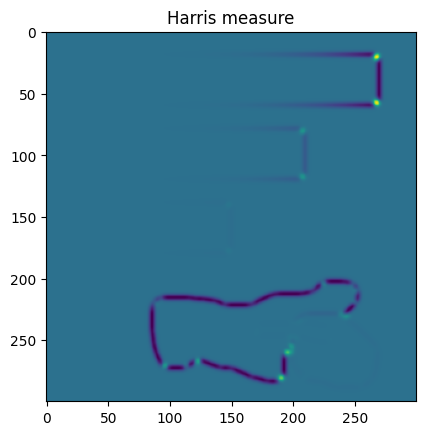

In [5]:
# Ex 6.4
# Harris measure using the structure tensor
def harris_measure(im, sigma, epsilon, k):
    """
    Computes the Harris measure R(x,y) of the input image.

    Args:
        im : (h,w) input image
        sigma : Gaussian width to compute derivatives
        epsilon : Gaussian width to compute the structure tensor
        k : sensitivity factor

    Returns:
        r : (h,w), Harris measure
    """
    C = structure_tensor(im, sigma, epsilon)
    a = C[0, 0]
    b = C[1, 1]
    c = C[0, 1]
    r = a * b - c**2 - k * (a + b) ** 2
    return r


k = 0.06
r = harris_measure(im, sigma, epsilon, k)
print(f"r: {r.shape}")

# Display images
plt.imshow(r)
plt.title("Harris measure")
plt.show()

# When epsilon is zero, the Gaussian distribution becomes a delta function,
# and the structure tensor becomes a constant tensor. There will not be any
# blurring in place. And the equations will be undefined.

r: [223102.60, -132061.03], tau = 0.02*r.max
16 corners found.


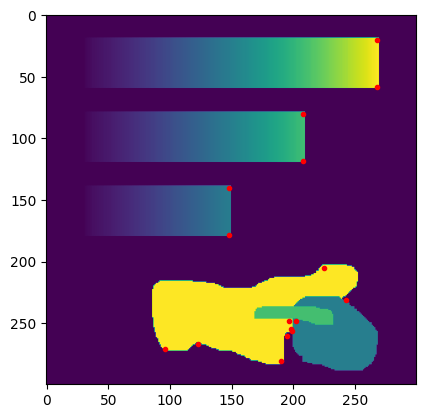

In [6]:
# Ex 6.5
# Corner detection with non-max suppression


def corner_detector(im, sigma, epsilon, tau):
    """
    Detects corners in the input image using the Harris measure
    with non-max suprrssion and thresholding.

    Args:
        im : input image
        sigma : Gaussian width to compute derivatives
        epsilon : Gaussian width to compute the structure tensor
        tau : threshold for Harris measure

    Returns:
        c : list of corner coordinates
    """
    r = harris_measure(im, sigma, epsilon, k)
    print(f"r: [{r.max():.2f}, {r.min():.2f}], tau = {tau/r.max():.2f}*r.max")

    # Perform 4-neigbourhood non-max suppression
    c = []
    for i in range(1, r.shape[0] - 1):
        for j in range(1, r.shape[1] - 1):
            if (
                r[i, j] > r[i + 1, j]
                and r[i, j] >= r[i - 1, j]
                and r[i, j] > r[i, j + 1]
                and r[i, j] >= r[i, j - 1]
                and r[i, j] > tau
            ):  # Threshold
                c.append([i, j])
    return c


# For TestIm2.png, the r-values are very high at the perfect corners.
# That's why the threshold is set below the recommended 0.1*r.max

tau = 5e3
c = corner_detector(im, sigma, epsilon, tau)
print(f"{len(c)} corners found.")

# Display corners
plt.imshow(im)
for pt in c:
    plt.plot(pt[1], pt[0], "r.")
plt.show()

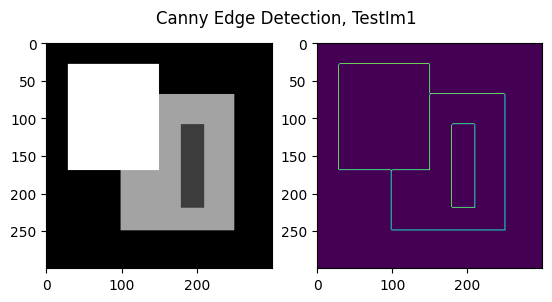

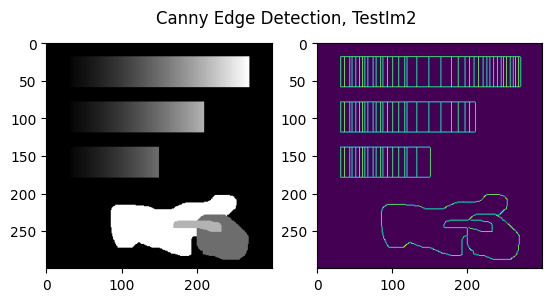

In [25]:
# Ex 6.6
# Canny edge detector

im1 = cv2.imread("media/week06_data/TestIm1.png", cv2.IMREAD_GRAYSCALE)
# plt.imshow(im1)
# plt.show()

# Loading astype(float) does not work for canny edge
t1 = 5
t2 = 100
edges = cv2.Canny(im1, t1, t2)
plt.suptitle(
    "Canny Edge Detection, TestIm1", y=0.8
)  # y controls title position
plt.subplot(121), plt.imshow(im1, cmap="gray")
plt.subplot(122), plt.imshow(edges)
plt.show()

im2 = cv2.imread("media/week06_data/TestIm2.png", cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(im2, t1, t2)
plt.suptitle("Canny Edge Detection, TestIm2", y=0.8)
plt.subplot(121), plt.imshow(im2, cmap="gray")
plt.subplot(122), plt.imshow(edges)
plt.show()